

$𝑥_𝑖(t+1) = 𝑥_𝑖 + \dfrac{𝛽_𝑖}{∑_{𝑗≠𝑖} 𝑤_{𝑖𝑗}}  ∑_{𝑗≠𝑖} 𝑤_{𝑖𝑗}   𝑥_{𝑖𝑗} ∙ tanh⁡(−𝛼_𝑖 (|𝑥_{𝑖𝑗} | − 𝜌_𝑖))$<br>

𝑥_𝑖 (𝑡),𝑥_𝑗 (𝑡) ∈ [0,1] --> Opinions of individuum 𝑥_𝑖 and its neighbors<br>
𝑥_{𝑖𝑗} (𝑡) = 𝑥_𝑗 (𝑡) - 𝑥_𝑖 (𝑡)  ∈ [-1,1] --> difference of opinion<br>
𝑤_𝑖𝑗 ∈ [0,1] --> social influence parameter (edge weights, allows unsymmetrical influence)<br>
𝛼_𝑖 ∈ [0,+…] --> controversy  of the topic (nonlinearity parameter,)<br>
𝜌_𝑖 ∈ [0,1]--> max opinion difference before repulsion<br>
𝛽_𝑖 --> coupling strength (stubborn agents)<br>


In [147]:
#import icecream

ModuleNotFoundError: No module named 'icecream'

In [206]:
import networkx as nx
import matplotlib.pyplot as plt
#import icecream as ic
#ic.configureOutput(includeContext=True, contextAbsPath=True)


import numpy as np
import random

class Environment:
    def __init__(self):
        self.graph = nx.Graph()  # Undirected graph

    def add_agent(self, agent):
        """Add an agent as a node in the graph."""
        self.graph.add_node(agent.id, agent=agent)

    def add_connection(self, agent1_id, agent2_id, weight=1):
        """Add a connection (edge) between two agents with a weight."""
        self.graph.add_edge(agent1_id, agent2_id, weight=weight)    


In [238]:
class Agent:
    def __init__(self, agent_id):
        self.agent_id = agent_id
        self.opinion = None
        self.beta =  None #coupling_strength
        self.rho = None #threshold of opiniondifferences
        self.alpha = None #controversity of the topic



    #def opinionupdate (self)

    def step(self, environment):
        # Calculate the opinion of the agent
        neighbors = environment.graph.neighbors(self.agent_id)  # Get neighbors of the agent
        #neighbor_opinions = [environment.graph.nodes[neighbor]['agent'].opinion for neighbor in neighbors] # Get opinions of neighbors
        weights = [environment.graph[self.agent_id][neighbor]['weight'] for neighbor in environment.graph.neighbors(self.agent_id)]
        opinion_fraction = 0.00
   
        for number, neighbor in enumerate(neighbors):
            neighbor_agent = environment.graph.nodes[neighbor]['agent']
            weight = environment.graph[self.agent_id][neighbor].get('weight', 1)  # Default weight is 1
            #influence = math.tanh(-neighbor_agent.a * (abs(neighbor_agent.opinion) - neighbor_agent.p))
            opinion_diff = neighbor_agent.opinion - self.opinion
            #print(f'opinion_diff: {opinion_diff}')
            
            opinion_fraction += weight * opinion_diff * np.tanh(- self.alpha * (abs(opinion_diff) - self.rho)) 
            
        
        if weights:  # Avoid division by zero
            self.opinion += self.beta / sum(weights) * opinion_fraction
        if self.opinion > 1:
            self.opinion = 1
        if self.opinion < 0:
            self.opinion = 0
    
    def step_norepulsion(self, environment):
        # Calculate the opinion of the agent
        neighbors = environment.graph.neighbors(self.agent_id)  # Get neighbors of the agent
        #neighbor_opinions = [environment.graph.nodes[neighbor]['agent'].opinion for neighbor in neighbors] # Get opinions of neighbors
        weights = [environment.graph[self.agent_id][neighbor]['weight'] for neighbor in environment.graph.neighbors(self.agent_id)]
        opinion_fraction = 0.00
   
        for number, neighbor in enumerate(neighbors):
            neighbor_agent = environment.graph.nodes[neighbor]['agent']
            weight = environment.graph[self.agent_id][neighbor].get('weight', 1)  # Default weight is 1
            #influence = math.tanh(-neighbor_agent.a * (abs(neighbor_agent.opinion) - neighbor_agent.p))
            opinion_diff = neighbor_agent.opinion - self.opinion
            #print(f'opinion_diff: {opinion_diff}')
            if opinion_diff > self.rho:
                continue
            opinion_fraction += weight * opinion_diff * np.tanh(- self.alpha * (abs(opinion_diff) - self.rho)) 
            
        
        if weights:  # Avoid division by zero
            self.opinion += self.beta / sum(weights) * opinion_fraction
        if self.opinion > 1:
            self.opinion = 1
        if self.opinion < 0:
            self.opinion = 0
        
            
        

In [239]:
class Model:
    def __init__(self, num_agents, connection_probability,beta,rho,alpha, repulsion= True):
        self.environment = Environment()
        self.agents = []
        self.repulsion = repulsion

        # Create agents and add them to the graph
        for i in range(num_agents):
            agent = Agent(i)
            agent.opinion = random.uniform(0,0.8)  # Initial opinion
            agent.beta =  beta #coupling_strength
            agent.rho = rho + random.uniform(0, 0.2) #threshold of opiniondifferences
            agent.alpha = alpha + random.uniform(0, 0.2) #controversity of the topic positiv definit
            self.agents.append(agent)
            self.environment.graph.add_node(i, agent=agent)

        # Add edges randomly between nodes
        for i in range(num_agents):
            for j in range(i + 1, num_agents):
                if random.random() < connection_probability:
                    weight = random.uniform(0.1, 1.0)  # Assign a random weight
                    self.environment.graph.add_edge(i, j, weight=weight)

    def step(self):
        if self.repulsion:
            for agent in self.agents:
                agent.step(self.environment)
        else:
            for agent in self.agents:
                agent.step_norepulsion(self.environment)

In [251]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_network(environment, layout):
    """
    Visualize the network with a consistent layout and color bar between 0 and 1.
    
    Args:
        environment: The Environment object containing the graph.
        layout: A dictionary of node positions (precomputed layout).
    """
    # Extract opinions for node colors
    node_colors = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]

    # Normalize opinions explicitly to the fixed range [0, 1]
    norm = plt.Normalize(vmin=0, vmax=1)  # Fix the color bar scale
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw the network using the consistent layout
    nx.draw(
        environment.graph,
        pos=layout,  # Use the precomputed layout
        with_labels=True,
        node_color=[sm.to_rgba(opinion) for opinion in node_colors],
        cmap="coolwarm",
        ax=ax
    )

    # Add the colorbar with the fixed scale
    sm.set_array([])  # Required for the colorbar
    fig.colorbar(sm, ax=ax, label="Opinion (0 to 1)")  # Fixed scale label
    plt.show()


def plot_opinion_distribution(environment, step):
    """
    Plot a bar chart showing the distribution of opinions in the system.

    Args:
        environment: The Environment object containing the graph.
        step: Current step number (for labeling the plot).
    """
    # Extract all opinions from agents
    opinions = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]
    
    # Create bins for the histogram (opinions in [0, 1], split into 10 bins)
    bins = np.linspace(0, 1, 11)  # Edges of bins: 0.0, 0.1, ..., 1.0
    
    # Create the histogram
    plt.hist(opinions, bins=bins, edgecolor='k', alpha=0.7, color='blue')
    
    # Add labels and title
    plt.xlabel("Opinion Value")
    plt.ylabel("Number of Agents")
    plt.title(f"Opinion Distribution at Step {step}")
    
    # Show the plot
    plt.show()

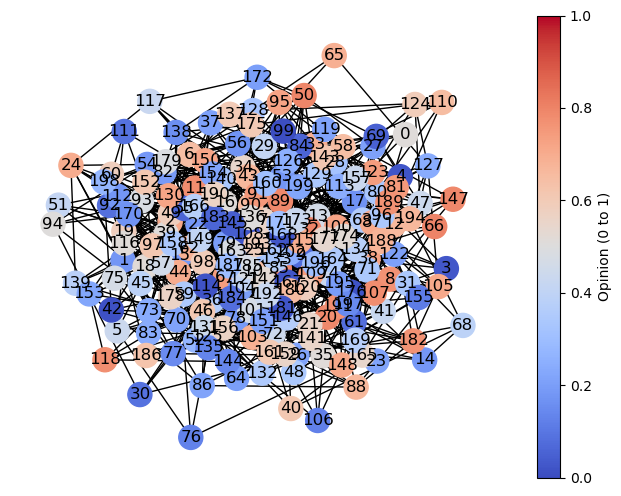

15 0.42312888277828703 0.0005420101604207661


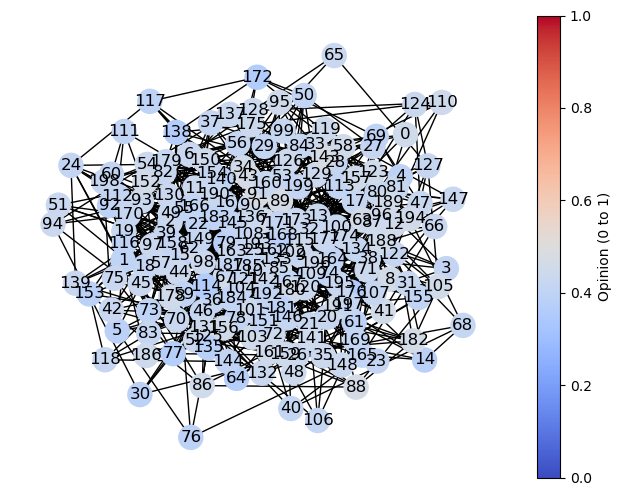

mean_opinion 0.42312888277828703, var_opinion 0.0005420101604207661, span_opinion 0.12687361523206098


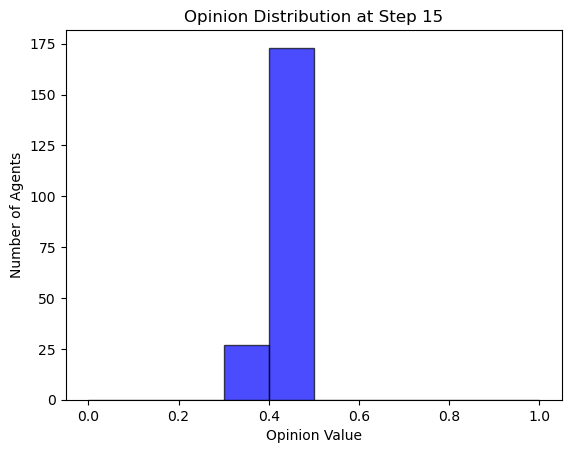

In [253]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  1 #coupling_strength
rho = 0.7  #threshold of opiniondifferences
alpha = 0.2  #controversity of the topic positiv definit

model = Model(num_agents, connection_probability,beta,rho,alpha)
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)
#random.seed(42)
# Run the simulation
def track_opinion_change(previous_opinions):
    """
    Calculate the average change in opinions between steps.

    Args:
        environment: The Environment object containing the graph.
        previous_opinions: List of opinions from the previous step.

    Returns:
        The average absolute change in opinions.
    """
    current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
    changes = [abs(current - previous) for current, previous in zip(current_opinions, previous_opinions)]
    return sum(changes) / len(changes)  # Average change


num_steps = 50
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions) < 0.003:
        current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
        mean_opinion = np.mean(current_opinions)
        var_opinion = np.var(current_opinions)

        print(step, mean_opinion, var_opinion)
        break
visualize_network(model.environment, layout)   
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions     
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion}")
plot_opinion_distribution(model.environment, step)
#print(f"Agent {agent.agent_id}: Opinion {agent.opinion}")
#(model.environment, layout)



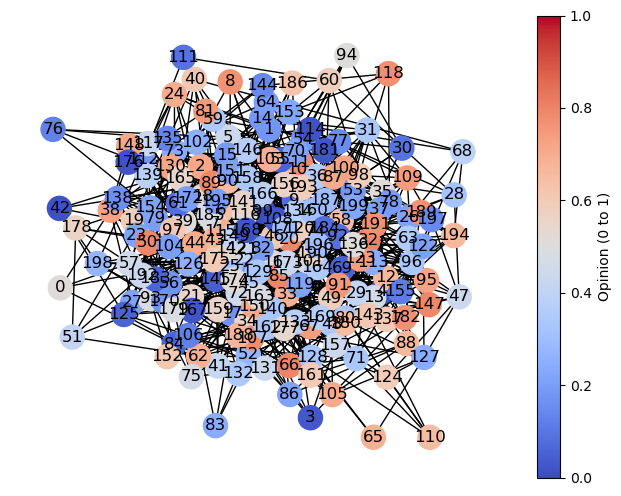

323 0.44412670404698157 0.23992334867479786


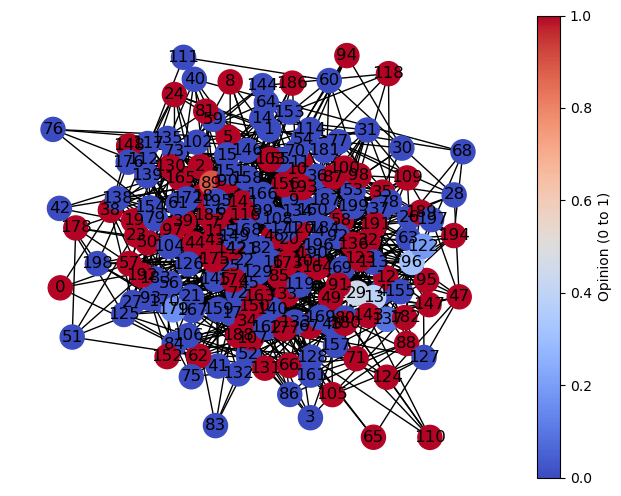

mean_opinion 0.44412670404698157, var_opinion 0.23992334867479786, span_opinion (1.0, 1.0, 0.0)


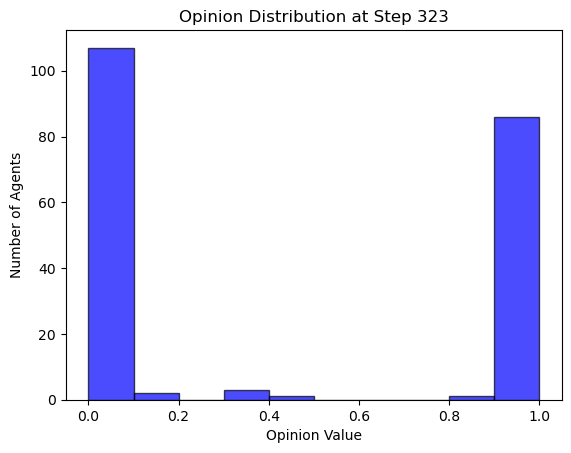

In [257]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
alpha = 0.0  #controversity of the topic positiv definit

model = Model(num_agents, connection_probability,beta,rho,alpha)
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)
#random.seed(42)
# Run the simulation
def track_opinion_change(previous_opinions):
    """
    Calculate the average change in opinions between steps.

    Args:
        environment: The Environment object containing the graph.
        previous_opinions: List of opinions from the previous step.

    Returns:
        The average absolute change in opinions.
    """
    current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
    changes = [abs(current - previous) for current, previous in zip(current_opinions, previous_opinions)]
    return sum(changes) / len(changes)  # Average change


num_steps = 1000
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions) < 0.000083:
        current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
        mean_opinion = np.mean(current_opinions)
        var_opinion = np.var(current_opinions)

        print(step, mean_opinion, var_opinion)
        break
visualize_network(model.environment, layout)  
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion, np.max(current_opinions), np.min(current_opinions)}")     
plot_opinion_distribution(model.environment, step)

#print(f"Agent {agent.agent_id}: Opinion {agent.opinion}")
#(model.environment, layout)



doesnt converge.. polarization is too high
when there is repulsion there is polariyation_

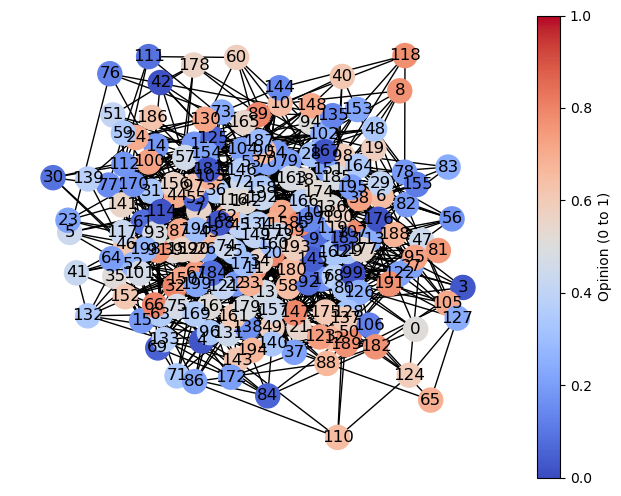

310 0.12333730472145646 0.10105539455344889


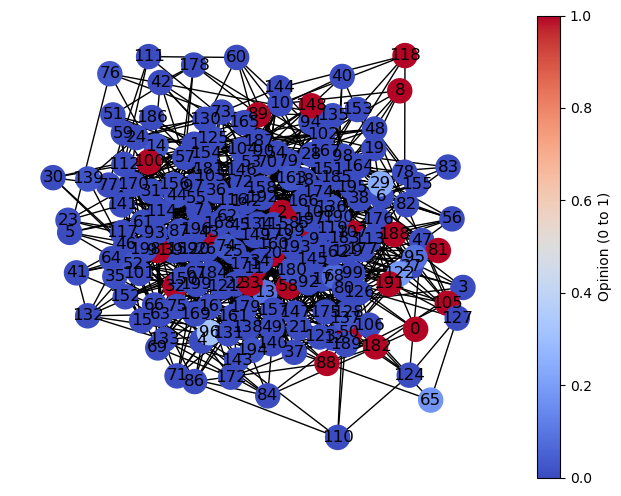

mean_opinion 0.12333730472145646, var_opinion 0.10105539455344889, span_opinion (1.0, 1.0, 0.0)


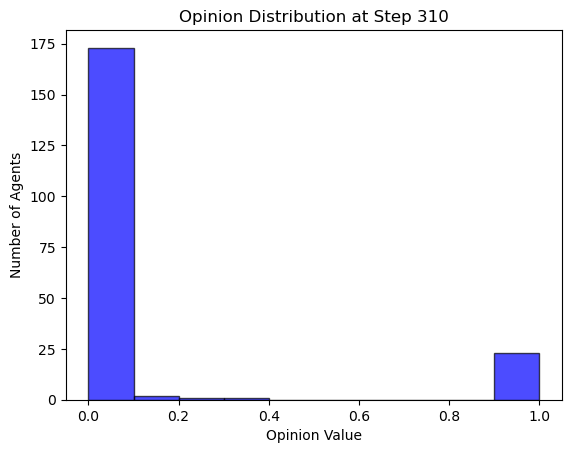

In [255]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  3 #coupling_strength
rho = 0.4  #threshold of opiniondifferences
alpha = 0.0  #controversity of the topic positiv definit

model = Model(num_agents, connection_probability,beta,rho,alpha)
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)
#random.seed(42)
# Run the simulation
def track_opinion_change(previous_opinions):
    """
    Calculate the average change in opinions between steps.

    Args:
        environment: The Environment object containing the graph.
        previous_opinions: List of opinions from the previous step.

    Returns:
        The average absolute change in opinions.
    """
    current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
    changes = [abs(current - previous) for current, previous in zip(current_opinions, previous_opinions)]
    return sum(changes) / len(changes)  # Average change


num_steps = 1000
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions) < 0.000083:
        current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
        mean_opinion = np.mean(current_opinions)
        var_opinion = np.var(current_opinions)

        print(step, mean_opinion, var_opinion)
        break
visualize_network(model.environment, layout)  
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions 
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion, np.max(current_opinions), np.min(current_opinions)}")
plot_opinion_distribution(model.environment, step)

#print(f"Agent {agent.agent_id}: Opinion {agent.opinion}")
#(model.environment, layout)



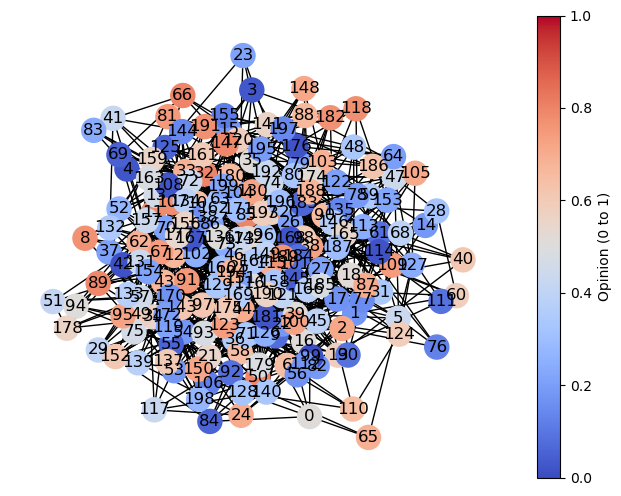

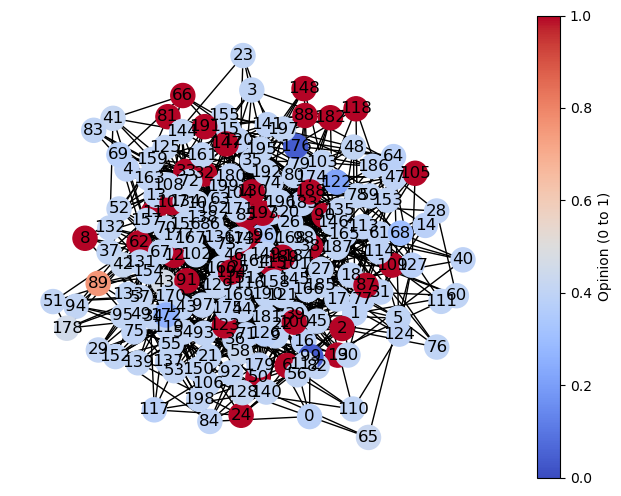

mean_opinion 0.5104575271253051, var_opinion 0.058589952189960555, span_opinion (0.9648319772019902, 1.0, 0.03516802279800974)


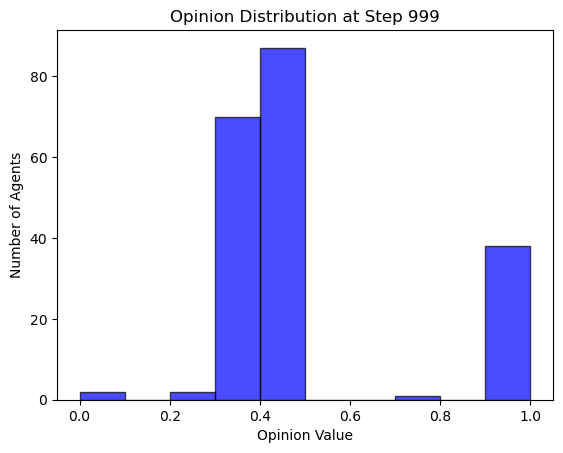

In [256]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
alpha = 0.0  #controversity of the topic positiv definit

model = Model(num_agents, connection_probability,beta,rho,alpha, repulsion= False)
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)
#random.seed(42)
# Run the simulation
def track_opinion_change(previous_opinions):
    """
    Calculate the average change in opinions between steps.

    Args:
        environment: The Environment object containing the graph.
        previous_opinions: List of opinions from the previous step.

    Returns:
        The average absolute change in opinions.
    """
    current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
    changes = [abs(current - previous) for current, previous in zip(current_opinions, previous_opinions)]
    return sum(changes) / len(changes)  # Average change


num_steps = 1000
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions) < 0.0000083:
        current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
        mean_opinion = np.mean(current_opinions)
        var_opinion = np.var(current_opinions)

        print(step, mean_opinion, var_opinion)
        break
visualize_network(model.environment, layout)  
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion, np.max(current_opinions), np.min(current_opinions)}")
plot_opinion_distribution(model.environment, step)
#print(f"Agent {agent.agent_id}: Opinion {agent.opinion}")
#(model.environment, layout)

